<a href="https://colab.research.google.com/github/lucas-fpaiva/matopiba_emissions/blob/main/code/groups.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perfil de emissões do matopiba

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
https://github.com/lucas-fpaiva/matopiba_emissions.git

# Limpeza e transformção dos dados 

In [ ]:
df = pd.read_csv('lucas_base_alterado_alterado.csv',
              error_bad_lines=False, encoding='latin-1',sep=';')#

df['emi_energia_2018']=pd.to_numeric(df['emi_energia_2018'],errors='coerce')
df.dropna(inplace=True)
df.columns

data=df[['ESTADOS', 'CIDADES', 'emi_geral_2018', 'emi_agro_2018', 
       'emi_mudterra_2018', 'emi_energia_2018', 'emi_residuos_2018', 
        'pib_2018']]

data['habitantes'] = 1000*df['pib_2018']/df['pib_percapta_2018']
data['habitantes']= data['habitantes'].astype(int)
df.dropna(inplace=True)
data.shape

C:\Users\CepaTech\Documents\Miniconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\CepaTech\Documents\Miniconda\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


(328, 9)

In [ ]:
def features(data_l):
    
    emi_2018 = ['emi_geral_2018','emi_agro_2018','emi_mudterra_2018', 'emi_energia_2018', 'emi_residuos_2018']
    
    l=["Agropecuária","MUT","Energia","Resíduos"]
    j=0
    for i in emi_2018[1:]:
        data_l[l[j]] = data_l[i]/data_l[emi_2018[0]]
        j+=1

    return data_l

In [ ]:
data_proces= features(data)
data_proces.head()


C:\Users\CepaTech\Documents\Miniconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ESTADOS,CIDADES,emi_geral_2018,emi_agro_2018,emi_mudterra_2018,emi_energia_2018,emi_residuos_2018,pib_2018,habitantes,Agropecuária,MUT,Energia,Resíduos
0,TO,Abreulândia,415469.12,127828.13,286357,530.51,753.48,52402.19,2564,0.307672,0.689238,0.001277,0.001814
1,MA,Açailândia,2012738.16,701929.89,1033654,221796.36,55357.90,2602790.66,111757,0.348744,0.513556,0.110196,0.027504
2,MA,Afonso Cunha,77780.74,7322.15,59017,10089.06,1352.53,50235.77,6468,0.094138,0.758761,0.129712,0.017389
3,MA,Água Doce do Maranhão,28598.69,6986.73,15176,3941.72,2494.25,86186.06,12488,0.244302,0.530654,0.137829,0.087216
4,TO,Aguiarnópolis,116760.47,20766.03,31678,62457.73,1858.71,124903.42,6571,0.177852,0.271308,0.534922,0.015919


# Agrupamento

In [ ]:
fontsize = 18

In [ ]:
import matplotlib.gridspec as gridspec


def silhouette_plot_(X,range_n,lim,best_k):
  nome = list(X.columns)

  kmeans_per_k = [KMeans(k,init = "k-means++", n_init=50, random_state=0).fit(X)
                for k in range(1, lim)]
  inertias = [model.inertia_ for model in kmeans_per_k]

  k_opt = number_of_clusters(inertias,[1,lim])

  fig = plt.figure(figsize = (15, 10), dpi = 300)
  gs = gridspec.GridSpec(11, 3)
  ax = fig.add_subplot(gs[0:4, :])
  ax.plot(range(1,lim), inertias, "bo-")
  ks = [k_opt-1,k_opt,k_opt+1]

  # print("k ótimo: ", k_opt)
  ax.plot(ks,inertias[k_opt-2:k_opt+1],"ro-",linewidth=2, markersize=12)

  ax.set_ylabel("WCSS", fontsize=fontsize)
  ax.set_xlabel("Número de grupos \n", fontsize=fontsize)
  ax.grid(True)
  ax.annotate('Cotovelo',
             xy=(k_opt, inertias[k_opt]+0.5),
             xytext=(0.3, 0.85),
             textcoords='figure fraction',
             fontsize=fontsize,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )

  j=0
   
  ax.text(-0.15/3, 1.1, 'a', transform=ax.transAxes, 
            size=22, weight='bold')
    
    
  for n_clusters in range_n:
    
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 0 for reproducibility.
    clusterer = KMeans(n_clusters = n_clusters, init = "k-means++", n_init=50, random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    if n_clusters==best_k:
      global model_top
      global labels 
      labels = cluster_labels
      model_top = clusterer

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10

    ax = fig.add_subplot(gs[6:11, j])
    ax.grid(True)
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.plot(np.arange(1., 0., -0.1) * 2000., np.arange(1., 0., -0.1))
    
    
    for i in range(n_clusters-1,-1,-1):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them      
      ith_cluster_silhouette_values = \
          sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i
    
  #   for i in range(1,k+1):
  # color.append(cm.nipy_spectral(float(i-1)*1.1 /k))

      color = cm.nipy_spectral(float(i)*1.1 / n_clusters)
      ax.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=1)

      # Label the silhouette plots with their cluster numbers at the middle
      ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples
      # print(i,len(ith_cluster_silhouette_values))
    
      ax.set_title("k = "+str(n_clusters),fontsize=fontsize)
    if j==1:
      ax.set_xlabel("Coeficiente de silhueta", fontsize=fontsize)
    if j==0:
        ax.set_ylabel("Grupos \n", fontsize=fontsize)
        ax.text(-0.15, 1.05, 'b', transform=ax.transAxes, 
            size=22, weight='bold')
    j+=1
    # The vertical line for average silhouette score of all the values
    ax.set_xlim([-0.2, 1])
      # The (n_clusters+1)*10 is for inserting blank space between silhouette
      # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
  plt.savefig("images/figure1.pdf", format="pdf", dpi=1000)
  plt.show()
  


def number_of_clusters(wcss,interval):
    x1, y1 = interval[0], wcss[0]
    x2, y2 = interval[1], wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

C:\Users\CepaTech\Documents\Miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1040: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "


For n_clusters = 5 The average silhouette_score is : 0.4214611840848838
For n_clusters = 6 The average silhouette_score is : 0.42444966752841917
For n_clusters = 7 The average silhouette_score is : 0.402317616351768


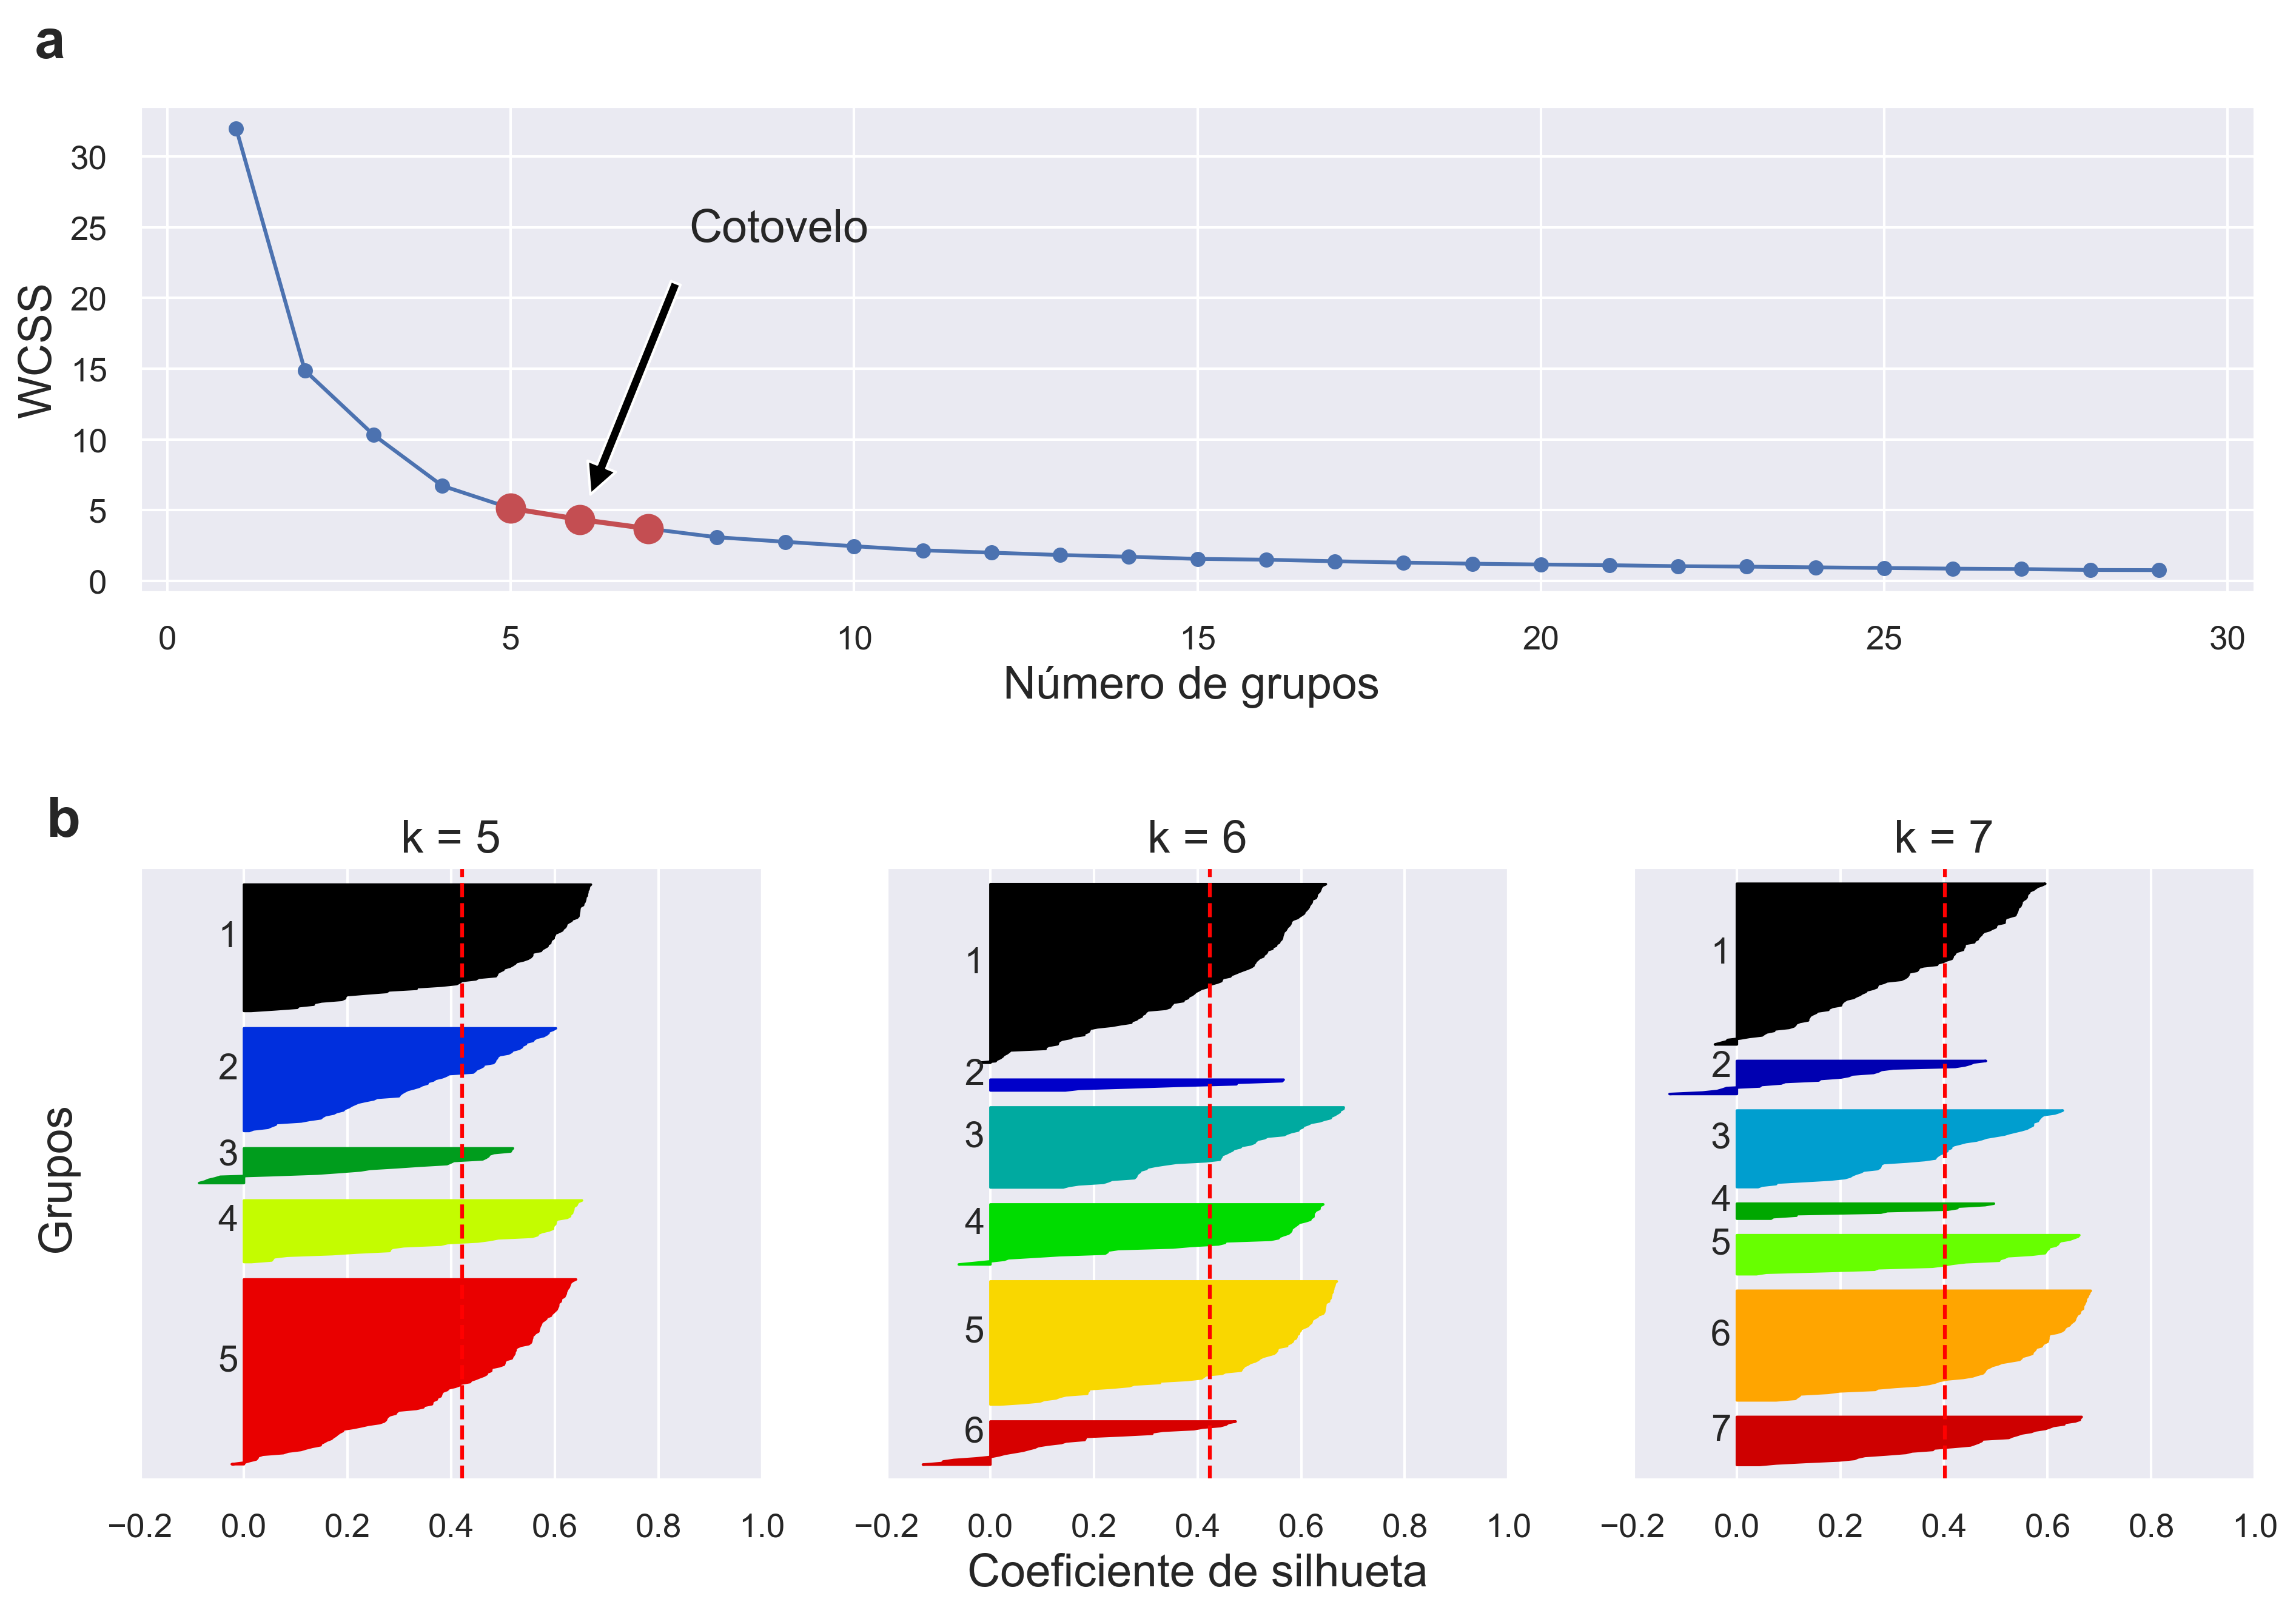

C:\Users\CepaTech\Documents\Miniconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
menork = 5 
maiork = 7
k =6
range_n = range(menork,maiork+1)
lim = 30
sns.set_theme()
sns.set(font_scale = 1.2)
silhouette_plot_(data_proces[["Agropecuária","MUT","Energia","Resíduos"]],range_n,lim,k)
data['grupo'] = model_top.predict(data_proces[["Agropecuária","MUT","Energia","Resíduos"]])


In [ ]:
data.to_csv('matopiba_groups.csv')

# Análise dos grupos

In [ ]:
#@markdown ##Rodar para Google Colab
from google.colab import drive
import os
drive.mount('/content/drive')
os.getcwd()
os.chdir('/content/drive/Shareddrives/MATOPIBA/analises')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
data = pd.read_csv('matopiba_groups.csv',index_col=0)
data.grupo = data.grupo+1
lista = []
for g in data.grupo:
    lista.append(str("G"+str(g)))


data['grupo_name'] = lista
data.head()

,ESTADOS,CIDADES,emi_geral_2018,emi_agro_2018,emi_mudterra_2018,emi_energia_2018,emi_residuos_2018,pib_2018,habitantes,Agropecuária,MUT,Energia,Resíduos,grupo,grupo_name
0,TO,Abreulândia,415469.12,127828.13,286357,530.51,753.48,52402.19,2564,0.307672,0.689238,0.001277,0.001814,1,G1
1,MA,Açailândia,2012738.16,701929.89,1033654,221796.36,55357.90,2602790.66,111757,0.348744,0.513556,0.110196,0.027504,1,G1
2,MA,Afonso Cunha,77780.74,7322.15,59017,10089.06,1352.53,50235.77,6468,0.094138,0.758761,0.129712,0.017389,5,G5
3,MA,Água Doce do Maranhão,28598.69,6986.73,15176,3941.72,2494.25,86186.06,12488,0.244302,0.530654,0.137829,0.087216,1,G1
4,TO,Aguiarnópolis,116760.47,20766.03,31678,62457.73,1858.71,124903.42,6571,0.177852,0.271308,0.534922,0.015919,2,G2


### Perfil dos grupos (descrição)

In [ ]:
data[['grupo','ESTADOS']]    #groupby('grupo').sum()

grupos = []
estados = ['MA','TO', 'PI','BA']
for i in range(1,7):
    linha =[]
    # print()
    grupo = data[data['grupo']==i]
    # print("Grupo "+str(i)+':')
    linha.append('G' +str(i))
    for est in estados:
        
        # print(est +"=" + str(len(grupo[grupo['ESTADOS'] == est]) ))
        linha.append(len(grupo[grupo['ESTADOS'] == est]))
    grupos.append(linha)
tab2 = pd.DataFrame(grupos,columns=['Grupo','MA','TO','PI','BA'])
tab2.head(7)

,Grupo,MA,TO,PI,BA
0,G1,52,47,11,7
1,G2,3,4,0,1
2,G3,15,33,4,1
3,G4,5,18,4,13
4,G5,46,18,12,5
5,G6,13,12,1,3


In [ ]:
os.chdir('/content/drive/Shareddrives/MATOPIBA/analises/images')

NameError: name 'os' is not defined

Grupo: MATOPIBA
Agropecuária    35.670178
MUT             54.518145
Energia          7.057391
Resíduos         2.754286
dtype: float64

Grupo: 1
Agropecuária    31.074964
MUT             62.714663
Energia          3.997788
Resíduos         2.212584
dtype: float64

Grupo: 2
Agropecuária    15.154200
MUT             16.867263
Energia         60.536933
Resíduos         7.441603
dtype: float64

Grupo: 3
Agropecuária    50.454921
MUT             44.231051
Energia          3.286759
Resíduos         2.027270
dtype: float64

Grupo: 4
Agropecuária    73.479459
MUT             17.322032
Energia          5.933140
Resíduos         3.265370
dtype: float64

Grupo: 5
Agropecuária    16.818369
MUT             78.470569
Energia          3.157808
Resíduos         1.553254
dtype: float64

Grupo: 6
Agropecuária    33.352995
MUT             35.039819
Energia         23.982114
Resíduos         7.625073
dtype: float64



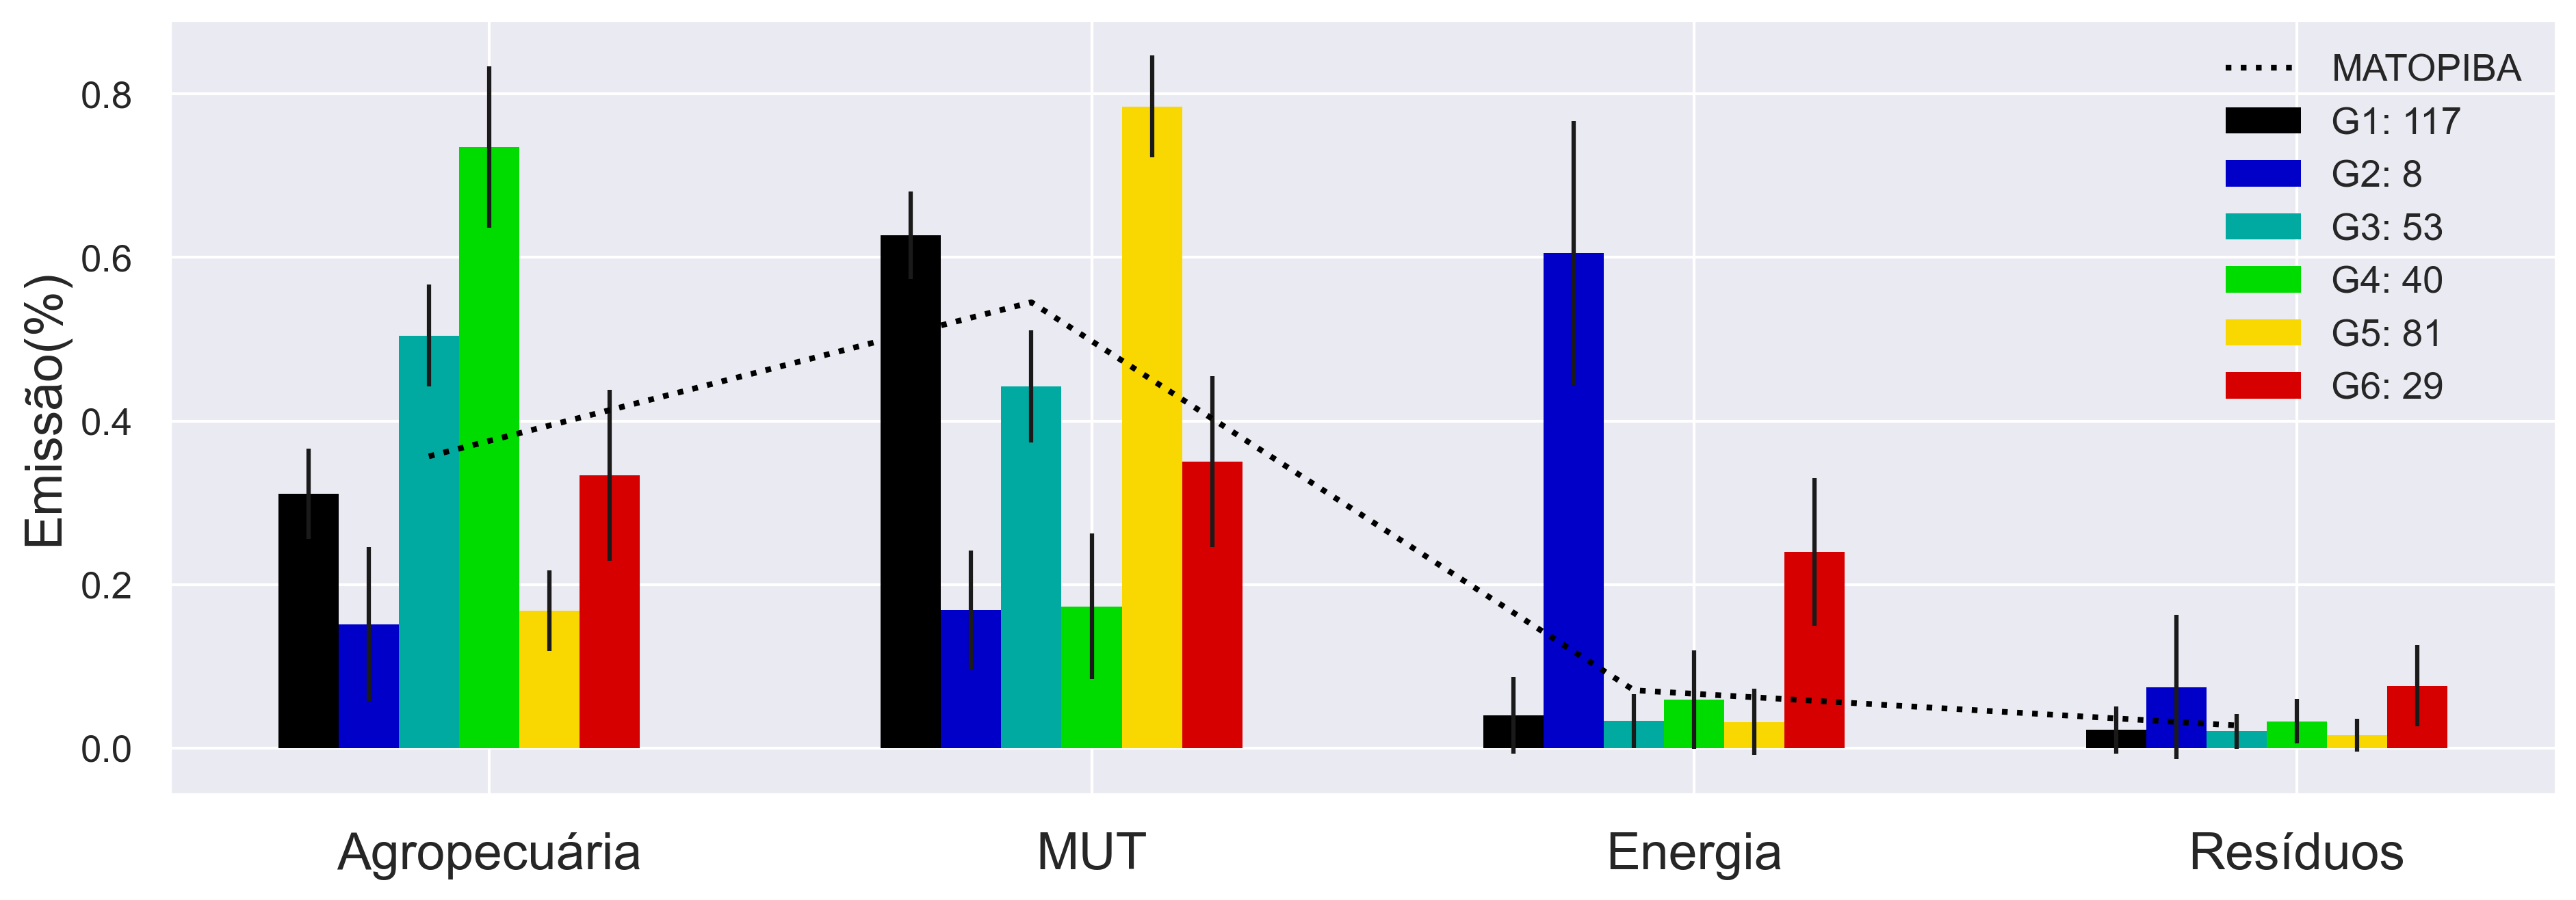

In [ ]:
from pandas.plotting import radviz

def bar_grupos(dados_sc,k):
  x = list(dados_sc.columns)[0:-1]
  
  fig = plt.figure(figsize = (15,5),dpi = 300)


  # plt.figure(figsize=(12, 5), dpi=300)
  j=0
  
  print("Grupo: MATOPIBA")
  print(dados_sc.drop(['grupo'],axis=1).mean()*100)
  print()
    

  barWidth = 0.1
  r = np.arange(4)
  r = [x-3*barWidth for x in r]
  for i in range(1,k+1):
    dado_g = dados_sc.loc[dados_sc['grupo']==i]
    dado_g = dado_g.drop(['grupo'],axis=1)
    dado_g = dado_g
    color=(cm.nipy_spectral(float(i-1)*1.1 /k))
    r = [x + barWidth for x in r]
    plt.bar(r, dado_g.mean(), width = barWidth, color = color, 
            edgecolor = 'white', lw=0.0, alpha=1, yerr=dado_g.std(), label=str('G'+str(i)+': '+str(dado_g.shape[0])))
    
    print("Grupo: "+str(i))
    print(dado_g.mean()*100)
    print()
    j+=1

  #color=(cm.nipy_spectral(float(i+1) /k))
  dado_g = dados_sc.drop(['grupo'],axis=1)
  r = [x-3*barWidth for x in r]
  plt.grid(True)
  plt.plot(r,dado_g.mean(),':',label=('MATOPIBA'), 
        linewidth=2,color = 'black') # markersize=12*(dado_g.shape[0]/dados_sc.shape[0]))

  plt.xticks([r + barWidth for r in range(len(dado_g.mean()))],x,fontsize=fontsize)
  plt.ylabel('Emissão(%)',fontsize=fontsize)
  # plt.xlabel([ "Agropecuária","MUT","Energia","Resíduos"],fontsize=fontsize)
  plt.legend()
  
  '''
  # statistical annotation
  x1, x2 = 2, 3   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
  y, h, col = tips['total_bill'].max() + 2, 2, 'k'
  plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
  plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
'''
    
    
bar_grupos(data[[ "Agropecuária","MUT","Energia","Resíduos",'grupo']],max(data.grupo))

plt.savefig("images/figure2b.pdf", format="pdf", dpi=1000)

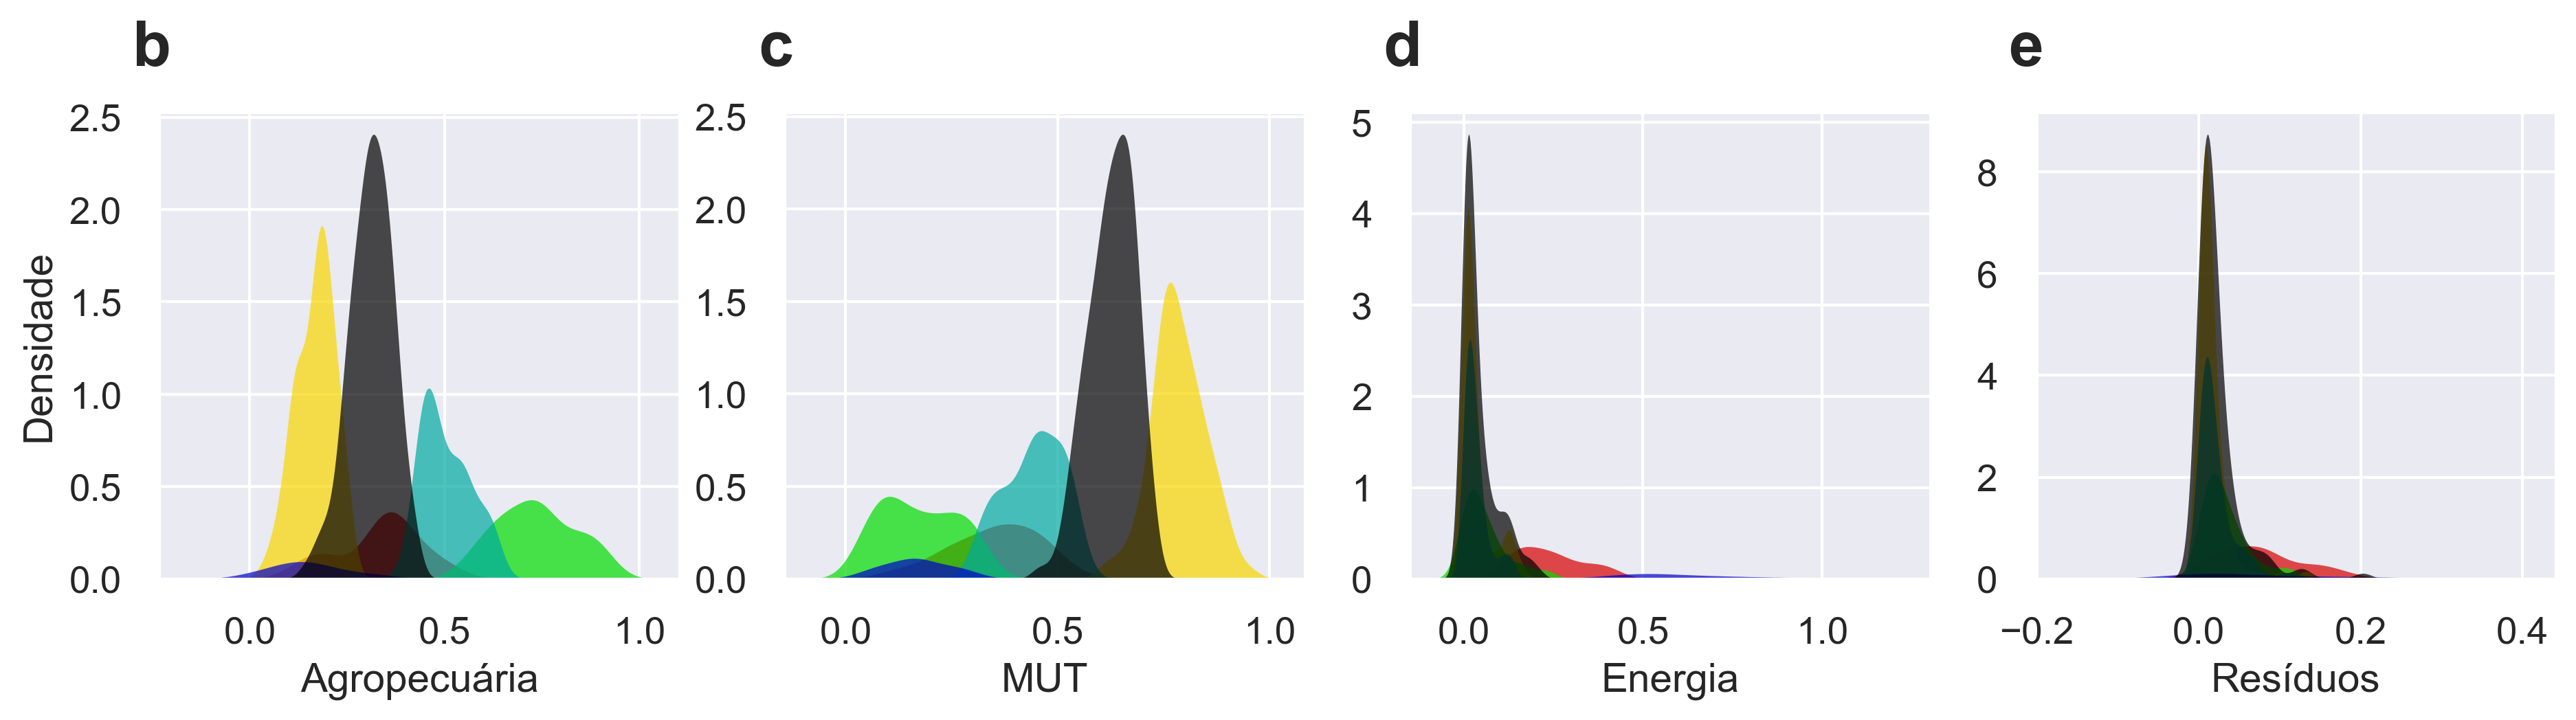

In [ ]:
color = []
for i in range(1,k+1):
  color.append(cm.nipy_spectral(float(i-1)*1.1/k))

fig = plt.figure(figsize = (15,3),dpi=300)

count=1
texto= ["b","c","d","e"]
for setor in ["Agropecuária","MUT","Energia","Resíduos"]:

    plt.subplot(1,4,count)    
    ax=sns.kdeplot(data=data, x=setor, hue="grupo",palette=color ,fill=True,
   alpha=.7, linewidth=0,
)
    ax.text(-0.15/3, 1.1, texto[count-1], transform=ax.transAxes, 
            size=22, weight='bold')
    ax.set_xlabel(setor, fontsize=fontsize)
    if count ==1:
        ax.set_ylabel("Densidade", fontsize=fontsize)
        ax.legend_.set_title(None)
    else: 
        ax.set_ylabel(" ", fontsize=fontsize)
    count+=1
    ax.legend([],[], frameon=False)


# axs[0][1]=ax.text(-0.15/3, 1.1, 'B', transform=ax.transAxes, 
#         size=22, weight='bold')

# axs[0][1]=sns.kdeplot(data=data, x="MUT", hue="grupo")
plt.savefig("images/figure2a.pdf", format="pdf", dpi=1000)        

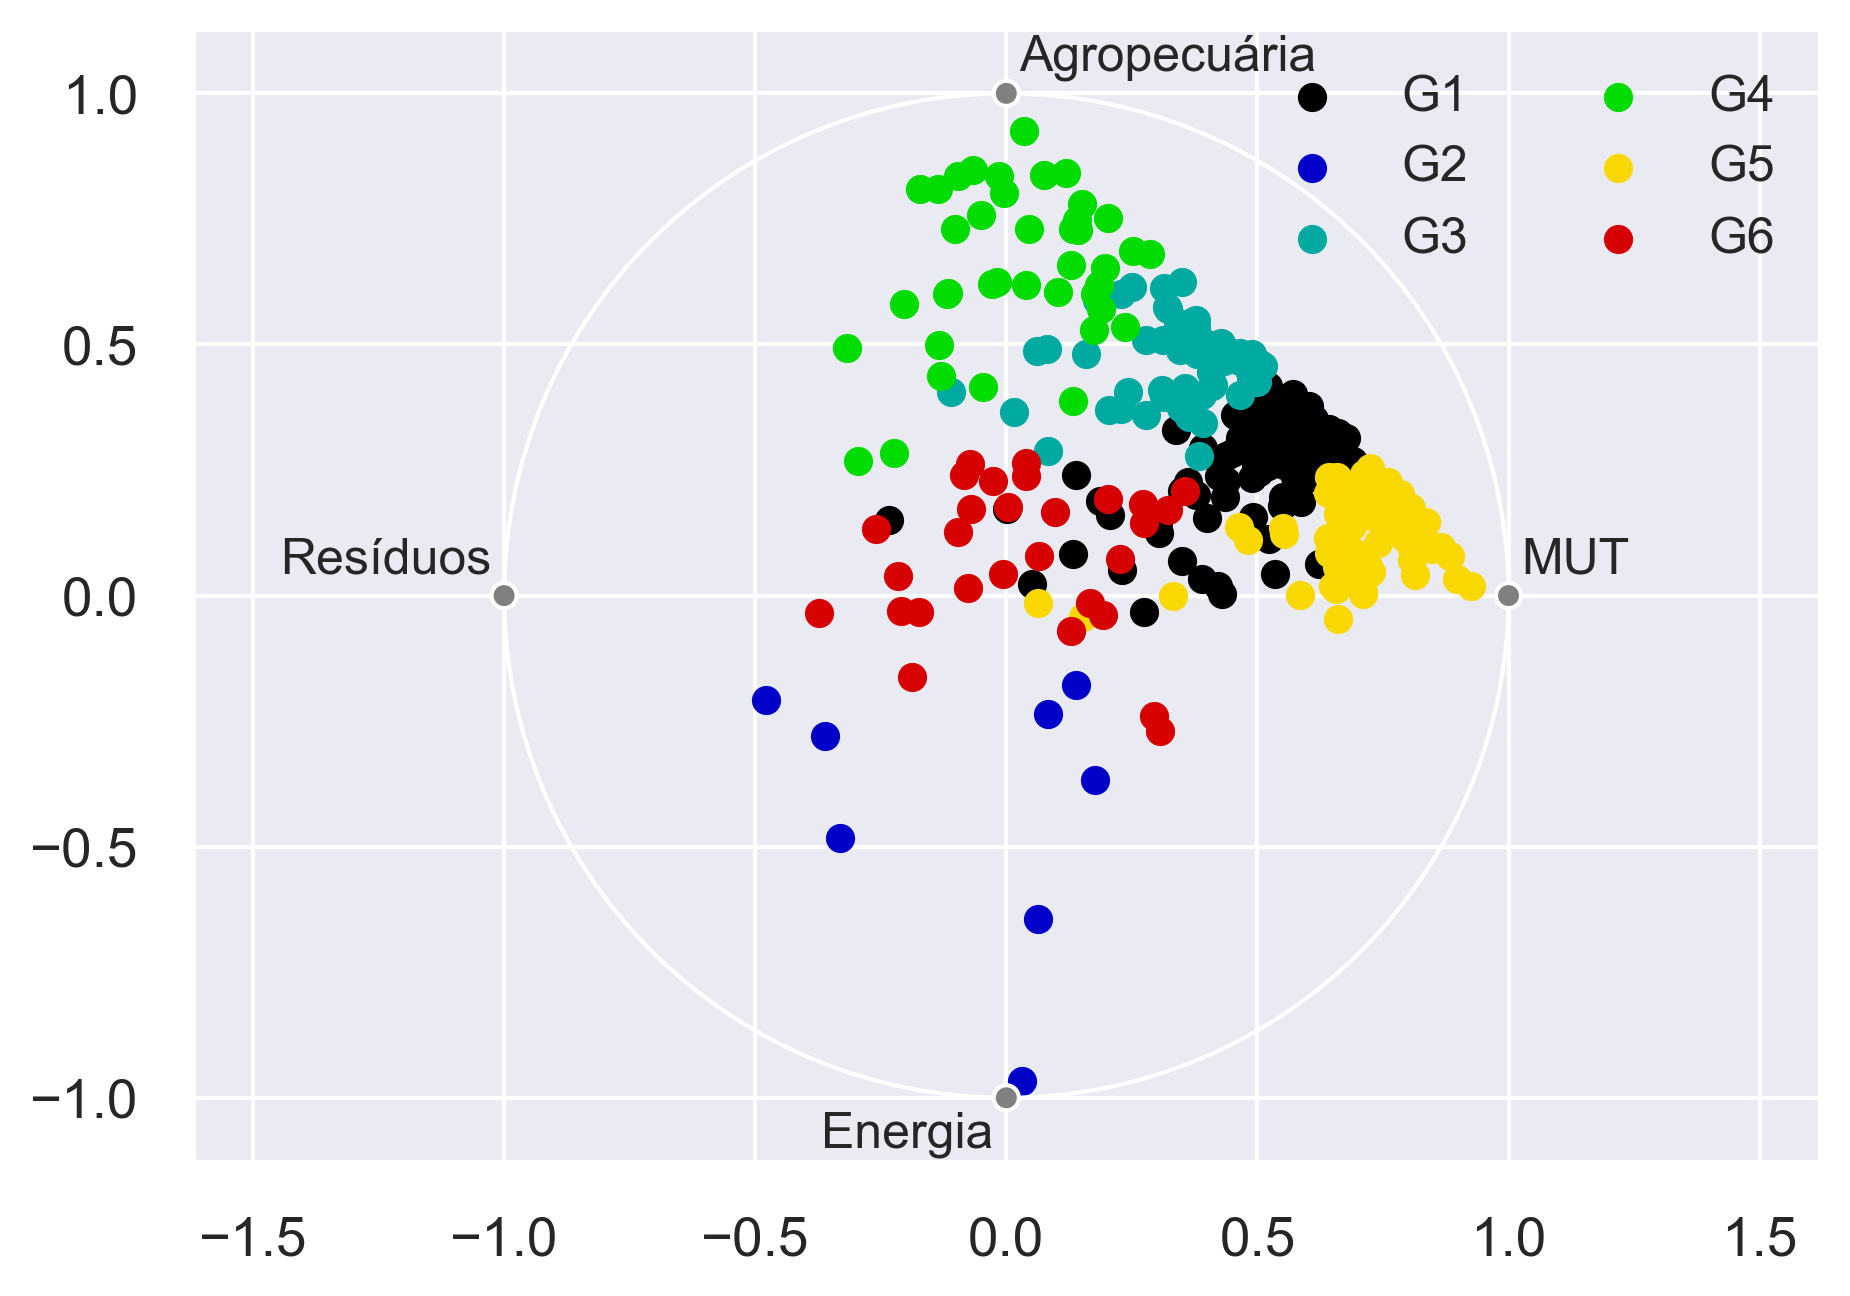

In [ ]:
from pandas.plotting import radviz
fig = plt.figure(figsize = (7,5),dpi = 300)

# ax = fig.add_subplot(221)
radviz(data[["MUT","Agropecuária","Resíduos","Energia",'grupo_name']].sort_values(by='grupo_name'), 'grupo_name',color = color)
plt.legend(loc='best',ncol=2,fontsize=12)
plt.savefig("images/figure3.pdf", format="pdf", dpi=1000)

#### Verificando diferenças significativas entre os grupos 

In [ ]:
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import bartlett

l=range(1,max(data.grupo)+1)

count=0

grupos =[]

ps_all = []

parametric = True
for coluna in ["Agropecuária","MUT","Energia","Resíduos"]:
    count+=1
    print(coluna)
    k=0

    ps=[]
    met = []
    for i in l:
        k+=1
        for j in l[k:]:
            ''' Verificando se pode usar teste parametrico'''
            
            cat1 = data[data['grupo']==i]
            cat2 = data[data['grupo']==j]
            
            #Verificando o tamanho das amostras
            if min(len(cat1[coluna]),len(cat2[coluna]))>20:
                parametric = True
            else: parametric = False
            
            #verificando normalidade
            if parametric:
                _, p_1 = stats.normaltest(cat1[coluna])
                if p_1>=0.05:
                    print(str('Normal ' + str(i)+ ' p ='), p_1)
                    parametric = True

                else: parametric = False
            
            if parametric:
                _, p_2 = stats.normaltest(cat2[coluna])
                if p_2>=0.05:
                    parametric = True
                else: parametric = False
            
            #Verificando Homocedasticidade
            if parametric:
                _, p_v = bartlett(cat1[coluna], cat2[coluna])
                if p_v>=0.05:
                    parametric = False
                
                
            # teste de diferenças
            if parametric:
                _,p=ttest_ind(cat1[coluna], cat2[coluna])
                if p<0.01:
                    met.append('t**')
                elif 0.01<p<0.05:
                    met.append('t*')
                else:
                    met.append('t')
                ps.append(p)
            else:
                _,p=mannwhitneyu(cat1[coluna], cat2[coluna])
                ps.append(p)
                if p<0.01:
                    met.append('U**')
                elif 0.01<p<0.05:
                    met.append('U*')
                else:
                    met.append('U')
                # print(str('Fail ' + str(i)+'_'+str(j)+' p ='))

     
            if count==1:
                grupos.append(str(str(i)+'_'+str(j)))
                
            
            
    if count==1:
        ps_all.append(grupos)
            
    ps_all.append(ps)
    ps_all.append(met)



Agropecuária
Normal 1 p = 0.20690724036272934
Normal 1 p = 0.20690724036272934
Normal 1 p = 0.20690724036272934
Normal 1 p = 0.20690724036272934
Normal 4 p = 0.23394249204667575
Normal 4 p = 0.23394249204667575
Normal 5 p = 0.26147594321068274
MUT
Normal 1 p = 0.10812359586216852
Normal 1 p = 0.10812359586216852
Normal 1 p = 0.10812359586216852
Normal 1 p = 0.10812359586216852
Normal 5 p = 0.7455903166335365
Energia
Resíduos


In [ ]:
ps_all = np.array(ps_all).transpose()
dif = pd.DataFrame(ps_all,columns=['grupos',"Agropecuária",'Método',"MUT",'Método',"Energia",'Método',"Resíduos",'Método'])
dif.head(20)

,grupos,Agropecuária,Método,MUT,Método,Energia,Método,Resíduos,Método
0,1_2,4.4486549071262185e-05,U**,1.2042211933653515e-06,U**,1.2042211933653515e-06,U**,0.08272396698219048,U
1,1_3,1.2187045642232775e-25,U**,9.597575133628476e-25,U**,0.40691689764497685,U,0.49597388986879276,U
2,1_4,3.9554499608136606e-73,t**,2.1590634806295103e-21,U**,0.01472599711860026,U*,0.0006667543150694224,U**
3,1_5,1.0294108597528082e-29,U**,2.238017778652018e-30,U**,0.08382419938098168,U,0.031152663213252302,U*
4,1_6,0.10705489599813256,t,2.038015665782083e-43,t**,5.516325344568816e-16,U**,1.155373140024373e-09,U**
5,2_3,3.109692593182338e-06,U**,3.109692593182338e-06,U**,3.109692593182338e-06,U**,0.09442737824069253,U
6,2_4,5.1107338223515976e-06,U**,0.47243096518540373,U,5.1107338223515976e-06,U**,0.38572691460861613,U
7,2_5,0.1700667637623569,U,1.738611269331612e-06,U**,1.738611269331612e-06,U**,0.03591295060883048,U*
8,2_6,0.0002807278382098792,U**,0.0002807278382098792,U**,1.0164421882806045e-05,U**,0.22472705749215438,U
9,3_4,1.2739207333008779e-15,U**,1.3858760291311922e-16,U**,0.02284822761694854,U*,0.0034219945997669412,U**


In [ ]:
os.chdir('/content/drive/Shareddrives/MATOPIBA/analises/')
dif.to_csv('tests.csv')

## Perfil dos grupos

In [ ]:
data[data['grupo']==2].head(8)

,ESTADOS,CIDADES,emi_geral_2018,emi_agro_2018,emi_mudterra_2018,emi_energia_2018,emi_residuos_2018,pib_2018,habitantes,Agropecuária,MUT,Energia,Resíduos,grupo,grupo_name
4,TO,Aguiarnópolis,116760.47,20766.03,31678,62457.73,1858.71,124903.42,6571,0.177852,0.271308,0.534922,0.015919,2,G2
63,TO,Cachoeirinha,281357.23,43839.96,40509,152112.38,44895.88,27213.28,2266,0.155816,0.143977,0.540638,0.159569,2,G2
125,TO,Fortaleza do Tabocão,348770.96,112367.29,64046,170948.90,1408.78,187372.01,2576,0.322181,0.183633,0.490147,0.004039,2,G2
142,MA,Imperatriz,1217486.75,158429.89,212990,557437.97,288628.89,7126745.97,258016,0.130129,0.174942,0.457860,0.237069,2,G2
165,TO,Lajeado,309727.49,26918.13,25883,218475.57,38450.79,67656.56,3100,0.086909,0.083567,0.705380,0.124144,2,G2
172,BA,Luís Eduardo Magalhães,924350.96,211918.03,242229,436433.90,33770.03,6184172.78,84752,0.229261,0.262053,0.472152,0.036534,2,G2
187,MA,Miranda do Norte,487057.62,46731.33,78702,353392.42,8231.86,554676.85,28001,0.095946,0.161587,0.725566,0.016901,2,G2
274,MA,Santo Antônio dos Lopes,3238329.58,46121.43,221223,2967252.35,3732.81,1914172.94,14533,0.014242,0.068314,0.916291,0.001153,2,G2


### Complementando as análises 

PermissionError: [Errno 13] Permission denied: 'images/figure4.pdf'

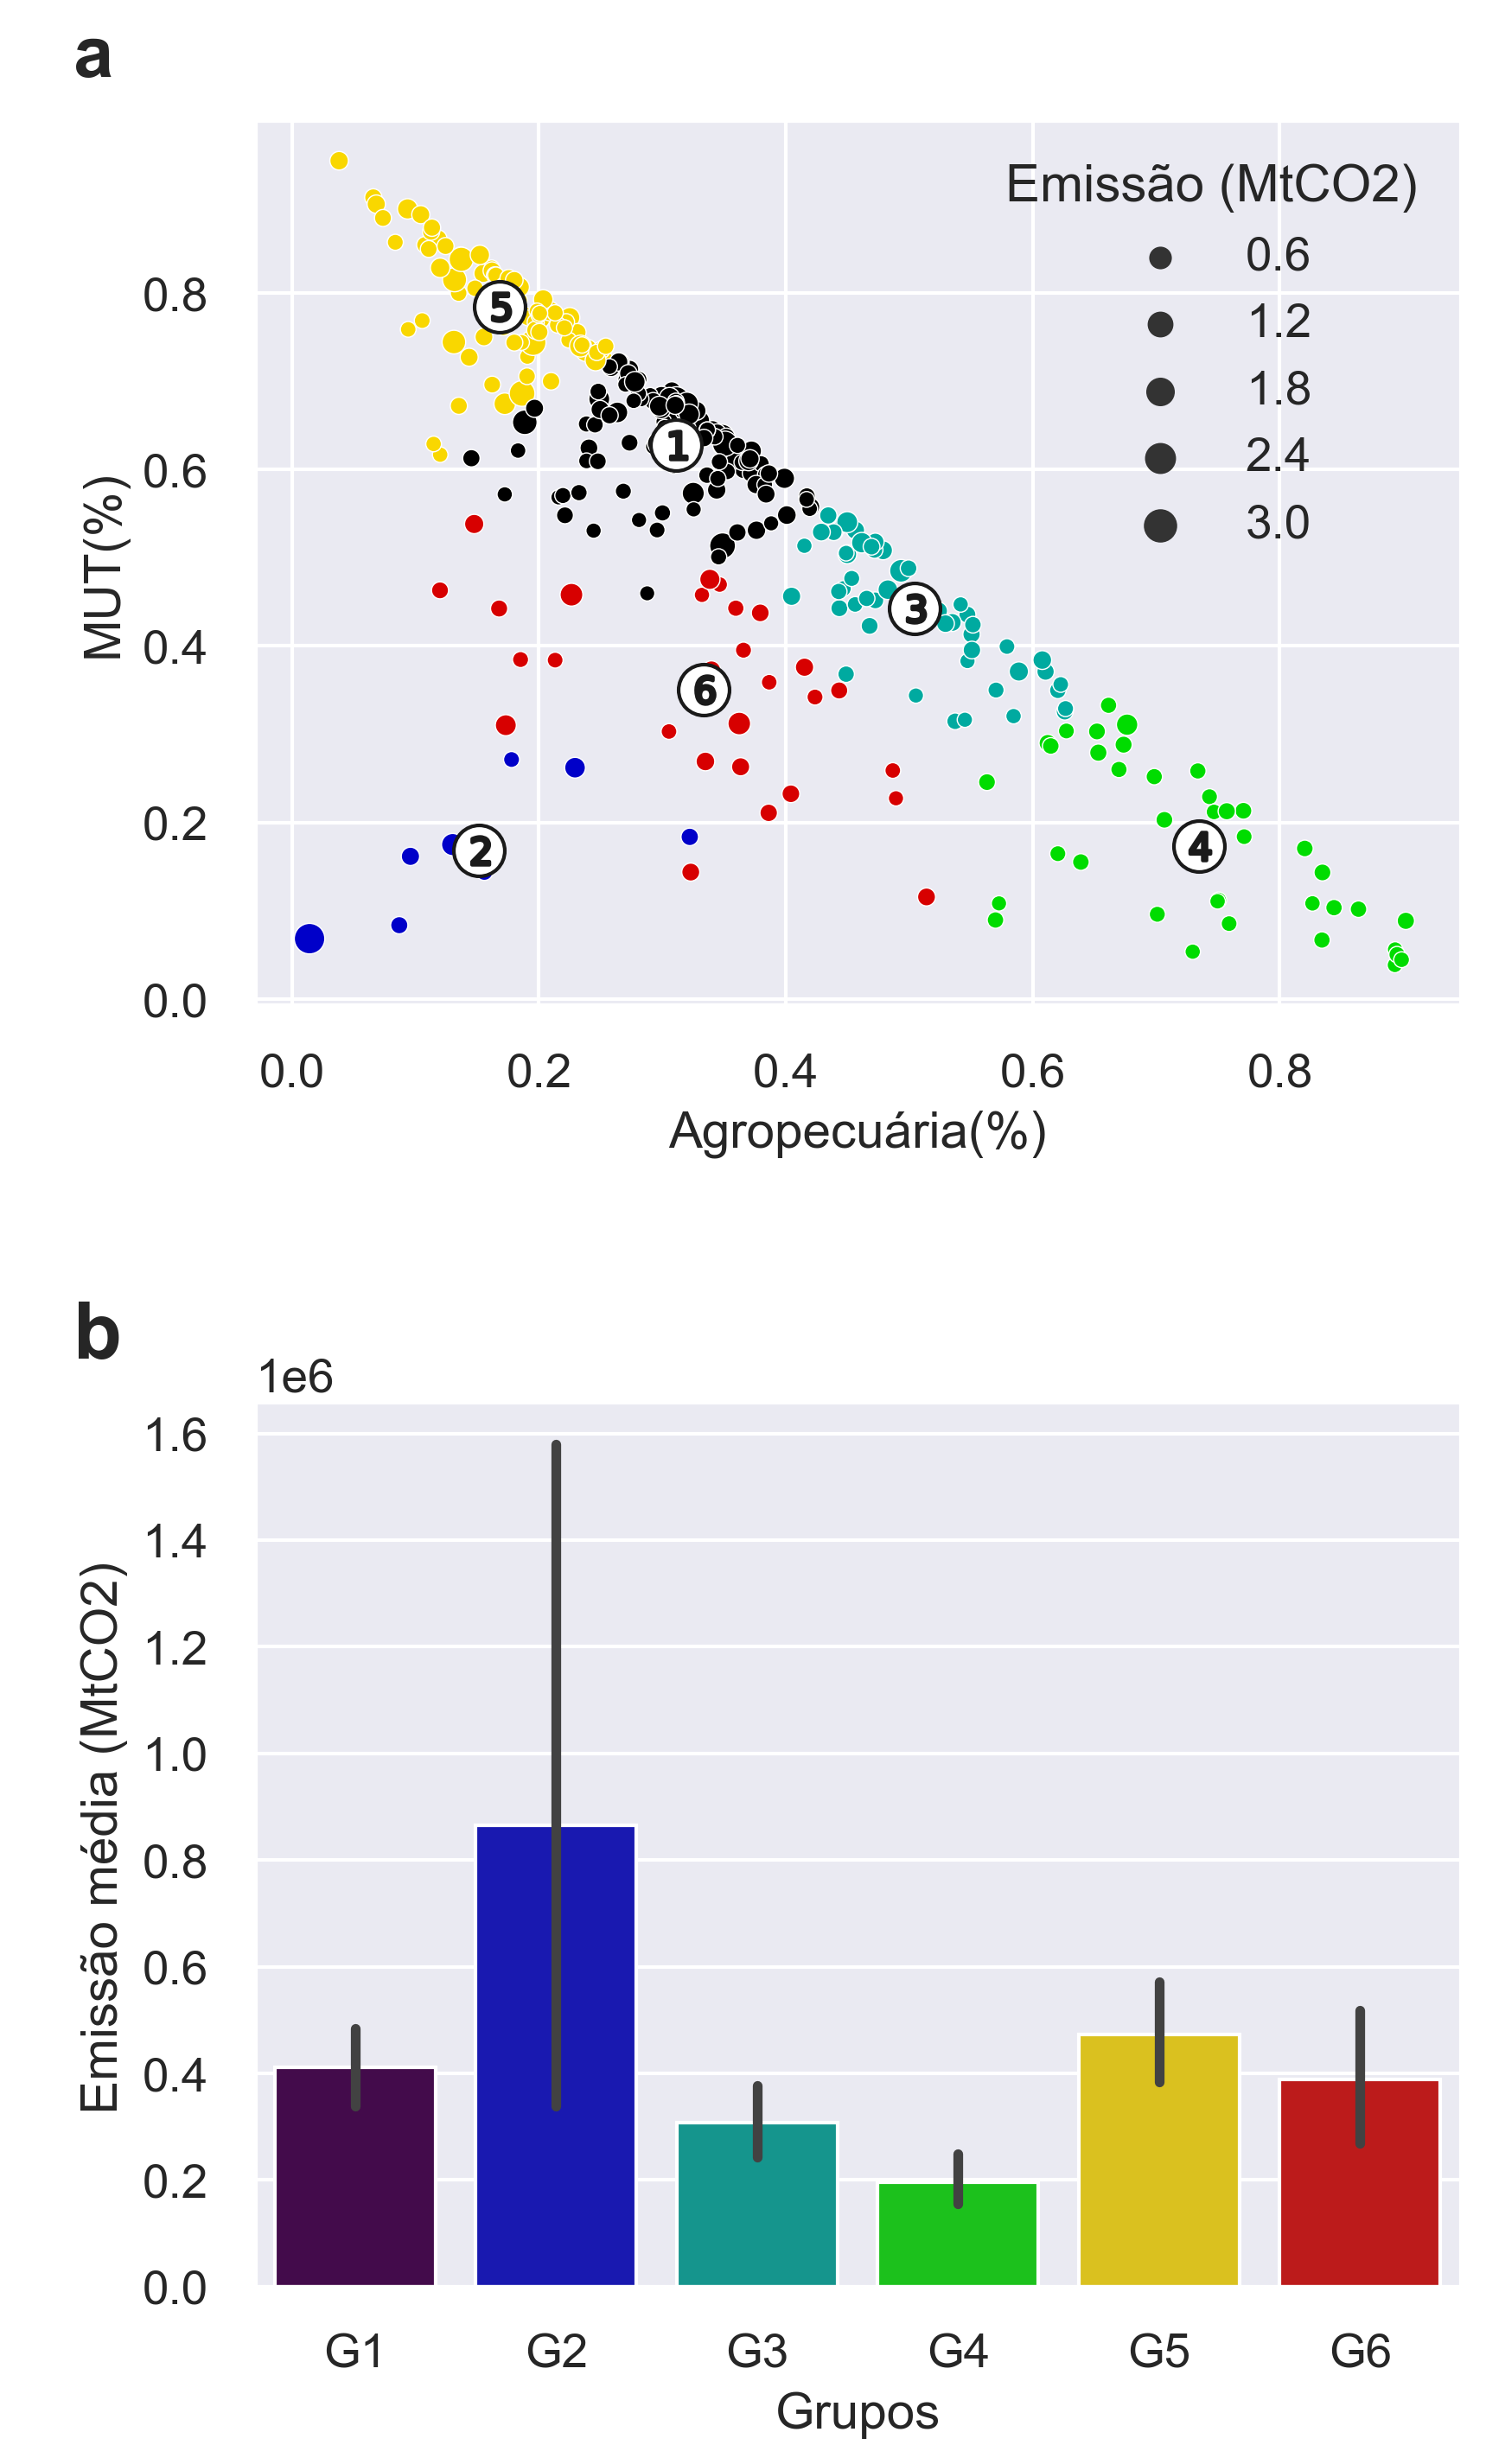

In [ ]:
import matplotlib.gridspec as gridspec

fontsize=14
fig = plt.figure(figsize = (6,12),dpi = 300)
gs = gridspec.GridSpec(13, 1)

ax = fig.add_subplot(gs[0:5, 0])

n_clusters=k

nome = ["Agropecuária","MUT","Energia","Resíduos"]
 
# colors = cm.nipy_spectral(data.grupo.astype(float)*0.9 / k)

color = []
for i in range(1,k+1):
  color.append(cm.nipy_spectral(float(i-1)*1.1 /k))


ax=sns.scatterplot(data=data , x="Agropecuária", y="MUT",  hue="grupo",legend = False,  alpha=1,
                   size ="emi_geral_2018",s=5000, marker='o',  palette=color) 
ax=sns.scatterplot(data=data , x="Agropecuária", y="MUT", size ="emi_geral_2018",alpha=0.0,
           palette=color) 
ax.set_ylabel('MUT(%)',fontsize=fontsize)
ax.set_xlabel('Agropecuária(%)', fontsize=fontsize)
ax.text(-0.15, 1.05, 'a', transform=ax.transAxes, 
    size=20, weight='bold')
plt.legend(title='Emissão (MtCO2)')



centers = model_top.cluster_centers_ 

# Draw white circles at cluster centers
grupos_count = data.groupby('grupo').count()
group_size = list(grupos_count['CIDADES'])

for i, c in enumerate(centers):
  color=(cm.nipy_spectral(float(i-1)*1.1 /k))
  
  ax= plt.scatter(c[0], c[1], marker='o',
          c='white', alpha=1, s=200, edgecolor='k') #*group_size[i]
  ax=plt.scatter(c[0], c[1], marker='$%d$' % int(i+1), alpha=1,
              s=60, edgecolor='k',c='k')#color

    
color = []
for i in range(1,k+1):
    color.append(cm.nipy_spectral(float(i-1)*1.1 /k))


ax = fig.add_subplot(gs[7:12, 0])    

ax = sns.barplot(x='grupo_name', y="emi_geral_2018",alpha=1,
                      data=data.sort_values(by=['grupo']),palette=color)
ax.set_xlabel('Grupos',fontsize=fontsize)
ax.set_ylabel('\n Emissão média (MtCO2)', fontsize=fontsize)
ax.text(-0.15, 1.05, 'b', transform=ax.transAxes, 
    size=22, weight='bold')
# ax.set_title("b)",fontsize=16)


# ax = fig.add_subplot(gs[1, 0])    

# plt.pie(data.sort_values(by=['grupo']), labels = labels, colors = color, autopct='%.0f%%')

# ax = sns.barplot(x='grupo_name', y="habitantes",alpha=1,
#                       data=data.sort_values(by=['grupo']),palette=color)
# ax.set_xlabel('Grupos',fontsize=16)
# ax.set_ylabel('Habitantes',fontsize=16)
# ax.text(-0.15, 1.05, 'c', transform=ax.transAxes, 
#     size=20, weight='bold')
# # ax.set_title("b)",fontsize=16)



# ax = fig.add_subplot(gs[1, 1])    


# ax = sns.barplot(x='grupo_name', y="pib_2018",alpha=1,
#                       data=data.sort_values(by=['grupo']),palette=color)
# ax.set_xlabel('Grupos',fontsize=16)
# ax.set_ylabel('PIB',fontsize=16)
# ax.text(-0.15, 1.05, 'd', transform=ax.transAxes, 
#     size=20, weight='bold')
# # ax.set_title("b)",fontsize=16)

# # plt.savefig("figure3ab.pdf", format="pdf", dpi=1000)

# ax = fig.add_subplot(gs[2,0])    

# data["Emissões/hab"] = data['emi_geral_2018']/data['habitantes']

# ax = sns.barplot(x='grupo_name', y="Emissões/hab",alpha=1,
#                       data=data.sort_values(by=['grupo']),palette=color)
# ax.set_xlabel('Grupos',fontsize=16)
# ax.set_ylabel('Emissões/hab',fontsize=16)
# ax.text(-0.15, 1.05, 'e', transform=ax.transAxes, 
#     size=20, weight='bold')


# ax = fig.add_subplot(gs[2, 1])    

# data["Emissões/PIB"] = data['emi_geral_2018']/data["pib_2018"]
# ax = sns.barplot(x='grupo_name', y="Emissões/PIB",alpha=1,
#                       data=data.sort_values(by=['grupo']),palette=color)
# ax.set_xlabel('Grupos',fontsize=16)
# ax.set_ylabel('Emissões/PIB',fontsize=16)
# ax.text(-0.15, 1.05, 'f', transform=ax.transAxes, 
#     size=20, weight='bold')



plt.savefig("images/figure4.pdf", format="pdf", dpi=1000)

C:\Users\CepaTech\Documents\Miniconda\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


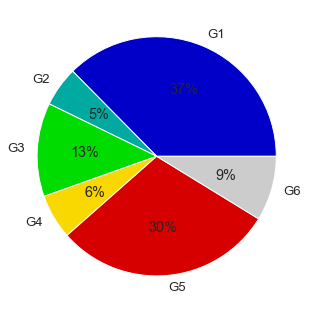

In [ ]:
color = []
for i in range(2,k+2):
    color.append(cm.nipy_spectral(float(i-1)*1.1 /k))
ax = fig.add_subplot()    

plt.pie(data.sort_values(by=['grupo']).groupby(by=['grupo_name']).sum()['emi_geral_2018'],
        labels = ['G1','G2','G3','G4','G5','G6'],colors = color, autopct='%.0f%%');


# plt.bar(data.sort_values(by=['grupo']).groupby(by=['grupo_name']).sum()['emi_geral_2018'], ['G1','G2','G3','G4','G5','G6'])
# #                       data=data.sort_values(by=['grupo']),palette=color)
# # ax.set_xlabel('Grupos',fontsize=16)
# # ax.set_ylabel('Habitantes',fontsize=16)
# # ax.text(-0.15, 1.05, 'c', transform=ax.transAxes, 
# #     size=20, weight='bold')
# # ax.set_title("b)",fontsize=16)




In [ ]:
# ax = fig.add_subplot(gs[2, 1])    

data["Emissões/PIB"] = data['emi_geral_2018']/data["pib_2018"]
ax = sns.bar(x='grupo_name', y="Emissões/PIB",alpha=1,
                      data=data.sort_values(by=['grupo']),palette=color)
ax.set_xlabel('Grupos',fontsize=16)
ax.set_ylabel('Emissões/PIB',fontsize=16)
ax.text(-0.15, 1.05, 'f', transform=ax.transAxes, 
    size=20, weight='bold')

AttributeError: module 'seaborn' has no attribute 'bar'

In [ ]:
data.sort_values(by=['grupo']).groupby(by=['grupo_name']).sum()['emi_geral_2018']

grupo_name
G1    48131814.39
G2     6923841.06
G3    16297153.55
G4     7803967.42
G5    38273789.30
G6    11266657.88
Name: emi_geral_2018, dtype: float64

In [ ]:
data[data.grupo==4].sort_values(by='MUT',ascending=True).head(10)   #1991731.82/53128.37 

,ESTADOS,CIDADES,emi_geral_2018,emi_agro_2018,emi_mudterra_2018,emi_energia_2018,emi_residuos_2018,pib_2018,habitantes,Agropecuária,MUT,Energia,Resíduos,grupo,grupo_name
158,PI,Júlio Borges,32342.73,28889.58,1243,959.93,1250.21,43181.85,5614,0.893233,0.038432,0.029680,0.038655,4,G4
310,BA,Sítio do Mato,88304.51,79360.18,3925,413.38,4605.95,94716.47,12965,0.898710,0.044448,0.004681,0.052160,4,G4
308,BA,Serra Dourada,172041.12,153980.59,8646,4191.11,5223.42,143661.41,17452,0.895022,0.050255,0.024361,0.030361,4,G4
31,PI,Avelino Lopes,42592.28,31072.20,2281,4581.86,4657.23,79068.61,11252,0.729527,0.053554,0.107575,0.109344,4,G4
203,TO,Novo Alegre,44702.81,39939.42,2506,1224.78,1032.61,27361.43,2332,0.893443,0.056059,0.027398,0.023099,4,G4
307,BA,Serra do Ramalho,188159.53,156965.76,12562,11772.33,6859.45,281390.64,31532,0.834216,0.066762,0.062566,0.036456,4,G4
215,BA,Paratinga,103374.05,78460.58,8824,8296.27,7793.20,215631.28,31852,0.758997,0.085360,0.080255,0.075388,4,G4
38,TO,Bandeirantes do Tocantins,324260.36,292527.36,28704,1441.43,1587.57,120313.00,3511,0.902137,0.088521,0.004445,0.004896,4,G4
52,BA,Bom Jesus da Lapa,204785.17,116684.55,18317,46790.87,22992.74,1010113.45,68609,0.569790,0.089445,0.228488,0.112277,4,G4
282,BA,São Félix do Coribe,141313.75,99040.17,13559,20950.02,7764.57,214330.55,15310,0.700853,0.095950,0.148252,0.054946,4,G4


In [ ]:
data_test = data[data.grupo!=6].copy()
data_test = data_test [data_test.grupo!=5]
data.corr()

,emi_geral_2018,emi_agro_2018,emi_mudterra_2018,emi_energia_2018,emi_residuos_2018,pib_2018,habitantes,Agropecuária,MUT,Energia,Resíduos,grupo,Emissões/hab,Emissões/PIB
emi_geral_2018,1.000000,0.747261,0.872807,0.511115,0.299075,0.465820,0.368341,-0.243941,0.145191,0.186741,-0.189285,-0.013920,0.429015,0.250861
emi_agro_2018,0.747261,1.000000,0.662324,0.073040,0.175938,0.305188,0.212207,0.202684,-0.106191,-0.062152,-0.236543,-0.102965,0.423299,0.289113
emi_mudterra_2018,0.872807,0.662324,1.000000,0.090117,0.134866,0.272518,0.252731,-0.353087,0.422376,-0.119537,-0.289614,0.005504,0.366594,0.333391
emi_energia_2018,0.511115,0.073040,0.090117,1.000000,0.272904,0.400189,0.253730,-0.163817,-0.204251,0.621335,0.086860,0.014395,0.190275,-0.089122
emi_residuos_2018,0.299075,0.175938,0.134866,0.272904,1.000000,0.761573,0.824445,-0.137870,-0.196206,0.420587,0.557810,0.119248,-0.119760,-0.152517
pib_2018,0.465820,0.305188,0.272518,0.400189,0.761573,1.000000,0.832116,-0.151108,-0.142280,0.416979,0.311393,0.088857,-0.088065,-0.230407
habitantes,0.368341,0.212207,0.252731,0.253730,0.824445,0.832116,1.000000,-0.189874,-0.103736,0.353691,0.492249,0.192714,-0.253899,-0.276963
Agropecuária,-0.243941,0.202684,-0.353087,-0.163817,-0.137870,-0.151108,-0.189874,1.000000,-0.783561,-0.175531,-0.011729,-0.044242,-0.037766,-0.093842
MUT,0.145191,-0.106191,0.422376,-0.204251,-0.196206,-0.142280,-0.103736,-0.783561,1.000000,-0.457061,-0.395450,-0.071004,0.099608,0.276995
Energia,0.186741,-0.062152,-0.119537,0.621335,0.420587,0.416979,0.353691,-0.175531,-0.457061,1.000000,0.450095,0.155711,-0.015221,-0.247806


In [ ]:
data[data.grupo==5].sort_values(by='emi_geral_2018',ascending=False).tail(10)

,ESTADOS,CIDADES,emi_geral_2018,emi_agro_2018,emi_mudterra_2018,emi_energia_2018,emi_residuos_2018,pib_2018,habitantes,Agropecuária,MUT,Energia,Resíduos,grupo,grupo_name,Emissões/hab,Emissões/PIB
297,MA,São Raimundo do Doca Bezerra,96507.46,19368.06,74979,573.94,1586.47,38455.46,5345,0.200690,0.776924,0.005947,0.016439,5,G5,18.055652,2.509591
169,MA,Lima Campos,91854.22,17077.32,68340,3293.73,3143.18,171593.58,11866,0.185918,0.744005,0.035858,0.034219,5,G5,7.740959,0.535301
236,TO,Porto Alegre do Tocantins,90923.62,18047.22,70886,433.75,1556.65,31090.82,3108,0.198488,0.779621,0.004770,0.017120,5,G5,29.254704,2.924452
175,PI,Manoel Emídio,86024.63,16429.82,66389,1538.62,1667.19,42088.65,5347,0.190990,0.771744,0.017886,0.019380,5,G5,16.088392,2.043891
2,MA,Afonso Cunha,77780.74,7322.15,59017,10089.06,1352.53,50235.77,6468,0.094138,0.758761,0.129712,0.017389,5,G5,12.025470,1.548314
199,MA,Nova Iorque,75488.19,16916.46,56360,833.62,1378.11,38728.44,4682,0.224094,0.746607,0.011043,0.018256,5,G5,16.123065,1.949167
286,PI,São Gonçalo do Gurguéia,73279.67,14649.45,56787,952.96,890.26,32269.84,3024,0.199912,0.774935,0.013004,0.012149,5,G5,24.232695,2.270841
330,MA,Urbano Santos,61787.54,7088.74,38858,7670.38,8170.42,191042.62,32775,0.114728,0.628897,0.124141,0.132234,5,G5,1.885203,0.323423
111,MA,Duque Bacelar,57245.47,10914.27,41670,1858.10,2803.10,77042.93,11296,0.190657,0.727918,0.032458,0.048966,5,G5,5.067765,0.743033
140,MA,Humberto de Campos,53128.37,6378.04,32767,8563.61,5419.73,161349.04,28497,0.120050,0.616751,0.161187,0.102012,5,G5,1.864350,0.329276


In [ ]:
1991731.82/1089394.29

1.8282928764019866

#### Testando correlações 

Pearson assumptions: https://www.statisticssolutions.com/pearson-correlation-assumptions/#:~:text=The%20assumptions%20are%20as%20follows,each%20variable%20should%20be%20continuous.

In [ ]:
_, p1 = stats.normaltest(data['Agropecuária'])
_, p2 = stats.normaltest(data['MUT'])
print("Teste de normalidade: ",p1,p2)
data[["Agropecuária", 'MUT']].corr()
## -0.783561

Teste de normalidade:  1.8695449038763365e-08 8.360050436410542e-06


,Agropecuária,MUT
Agropecuária,1.000000,-0.783561
MUT,-0.783561,1.000000


In [ ]:
#excluindo o grupo 2
_, p1 = stats.normaltest(data['Agropecuária'][data.grupo !=2])
_, p2 = stats.normaltest(data['MUT'][data.grupo !=2])
print("Teste de normalidade: ",p1,p2)
data[["Agropecuária", 'MUT']][data.grupo !=2].corr()
## -0.783561

Teste de normalidade:  2.6981531863338655e-08 2.5538535434967395e-05


,Agropecuária,MUT
Agropecuária,1.000000,-0.882981
MUT,-0.882981,1.000000


In [ ]:
#excluindo o grupo 2 
_, p1 = stats.normaltest(data['Agropecuária'][data.grupo !=2][data.grupo !=6])
_, p2 = stats.normaltest(data['MUT'][data.grupo !=2][data.grupo !=6])
print("Teste de normalidade: ",p1,p2)
data[["Agropecuária", 'MUT']][data.grupo !=2][data.grupo !=6].corr()
## -0.783561

Teste de normalidade:  3.967594364228804e-07 6.673344850383256e-07


C:\Users\CepaTech\Documents\Miniconda\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,Agropecuária,MUT
Agropecuária,1.000000,-0.954353
MUT,-0.954353,1.000000


# Extra

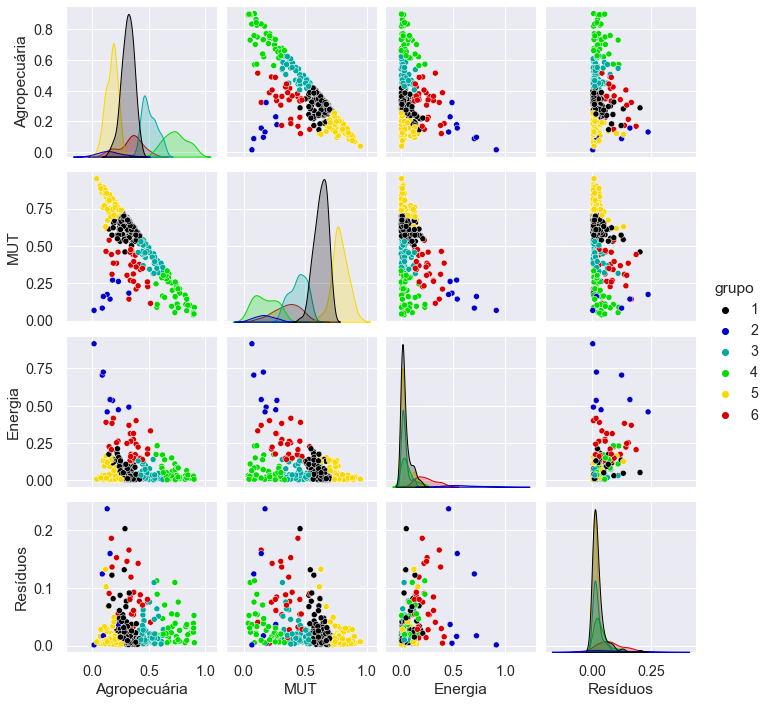

In [ ]:
k=6 #número de grupos
color = []
for i in range(1,k+1):
  color.append(cm.nipy_spectral(float(i-1)*1.1 /k))

# plt.figure(figsize = (5,6),dpi=100)
sns.set(font_scale = 1.3)

s = sns.pairplot(data[[ "Agropecuária","MUT","Energia","Resíduos",'grupo']], hue="grupo",palette=color) #"Paired"
#plt.savefig("figure1.pdf", format="pdf", dpi=1000)

<AxesSubplot:>

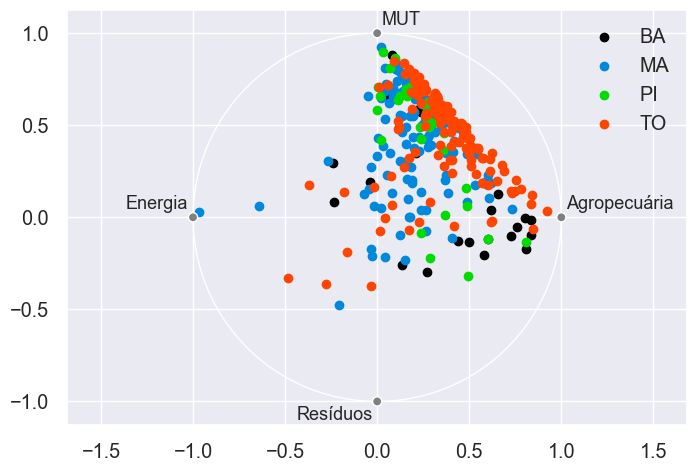

In [ ]:
fig = plt.figure(dpi = 100)

color = []
for i in range(1,4+1):
  color.append(cm.nipy_spectral(float(i-1)*1.1/4))

radviz(data[["Agropecuária","MUT","Energia","Resíduos",'ESTADOS']].sort_values(by='ESTADOS'), 'ESTADOS',color = color)

In [ ]:
df_loc = pd.read_csv('cidades_loc.csv',error_bad_lines=False,encoding='latin-1')

df_loc = df_loc.loc[df_loc['codigo_uf'].isin([17,21,22,29])]
df_loc['codigo_uf'] = df_loc['codigo_uf'].map({17:'TO',
                             21:'MA',
                             22:'PI',
                             29:'BA'},
                             na_action=None)
df_loc.rename(columns={"nome":"CIDADES",'codigo_uf':'ESTADOS'}, inplace=True)
df_loc['label'] = df_loc["CIDADES"]+df_loc['ESTADOS']

In [ ]:
df_graf= data[['ESTADOS',	'CIDADES',	'grupo','emi_geral_2018']]
df_graf['label']= df_graf["CIDADES"]+df_graf['ESTADOS']
df_graf['grupo'] = df_graf['grupo'].astype(str)

df_graf.insert(0, 'lat', df_graf['label'].replace(df_loc[['label']].values, df_loc['latitude'].values))
df_graf.insert(1, 'long', df_graf ['label'].replace(df_loc['label'].values, df_loc['longitude'].values))

df_graf.head()

C:\Users\CepaTech\Documents\Miniconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\CepaTech\Documents\Miniconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,lat,long,ESTADOS,CIDADES,grupo,emi_geral_2018,label
0,-9.62101,-49.1518,TO,Abreulândia,1,415469.12,AbreulândiaTO
1,-4.94714,-47.5004,MA,Açailândia,1,2012738.16,AçailândiaMA
2,-4.13631,-43.3275,MA,Afonso Cunha,5,77780.74,Afonso CunhaMA
3,-2.84048,-42.1189,MA,Água Doce do Maranhão,1,28598.69,Água Doce do MaranhãoMA
4,-6.55409,-47.4702,TO,Aguiarnópolis,2,116760.47,AguiarnópolisTO


No handles with labels found to put in legend.


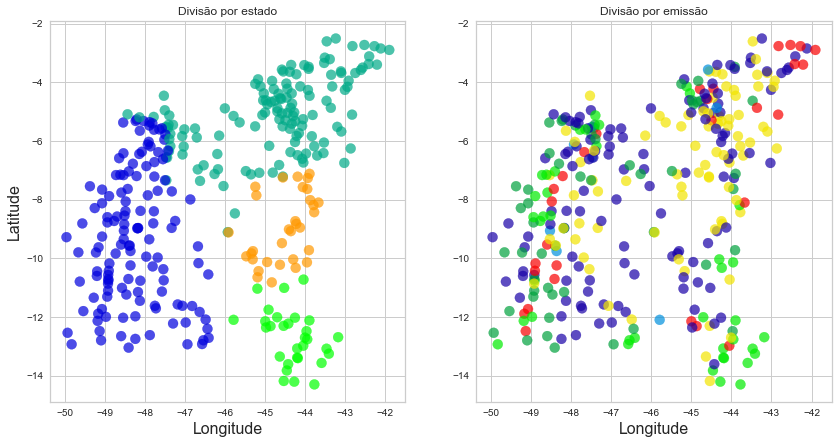

In [ ]:
#@markdown

k=6
plt.figure(figsize=(14,7))
plt.subplot(121)

color = []
for j in df_graf["ESTADOS"]:
  if j=="TO":
    i=1
  if j=="MA":
    i=2
  if j=="BA":
    i=3
  if j=="PI":
    i=4
  color.append(cm.nipy_spectral(float(i)/5))

plt.title("Divisão por estado")
plt.ylabel("Latitude",fontsize=16)
plt.scatter(df_graf["long"],df_graf["lat"], s=100, c=color, alpha=0.7) #, s=df_graf['emi_geral_2018']/10000
plt.xlabel("Longitude",fontsize=16)
# plt.ylabel("Latitude",fontsize=16)
plt.legend()

color = []

plt.subplot(122)
for j in df_graf['grupo']:
  color.append(cm.nipy_spectral(float(j) /(k+1)))

plt.scatter(df_graf["long"]*1,df_graf["lat"]*1, s=100,  c=color, alpha=0.7)#s=df_graf['emi_geral_2018']/10000,
plt.title("Divisão por emissão")
plt.xlabel("Longitude",fontsize=16)



plt.show()


In [ ]:
import json
br_estados = 'br_states.json'
geo_json_data = json.load(open(br_estados))

from branca.colormap import linear

colormap = linear.YlOrRd_09.scale(1,10)

##@markdown
# del mapa
import folium
from folium.plugins import MarkerCluster
mapa =folium.Map(	
    tiles='Stamen Toner',
    zoom_start=20
)
lat = list(df_graf['lat'])
longe = list(df_graf['long'])
name = list(df_graf['CIDADES'])
grupo = list(df_graf['grupos'])
color = ['black','darkpurple','blue',  'green','lightgreen','orange','red']
# color = []
# for j in range(0,k):
#   color.append(cm.nipy_spectral(float(j) /k))

# folium.GeoJson(
#     geo_json_data,
#    style_function=lambda feature: {
#         'fillColor': colormap(df_graf[feature['id']]),
#         'color': 'black',
#         'weight': 0.3,
#     }
# ).add_to(mapa)
marker_cluster = MarkerCluster(overlay=False,
    control=True).add_to(mapa)
for i in range(0,len(lat)):
  # folium.Marker()
  # folium.Marker(
  #     [lat[i] ,longe[i]],
  #     icon=folium.Icon(color=color[int(grupo[i])]),
  #     popup=str('<i>' +name[i]+ ': G' +grupo[i]+ '</i>'), 
  #     tooltip=str(name[i]+ ': G' +grupo[i]),
  #     draggable = True,
  #     ).add_to(mapa)

  
  folium.Marker([lat[i] ,longe[i]], popup=str('<i>' +name[i]+ ': G' +grupo[i]+ '</i>')).add_to(marker_cluster)
  # folium.CircleMarker(
  #   location=[lat[i] ,longe[i]],
  #   popup=str('<i>' +name[i]+ ': G' +grupo[i]+ '</i>'), 
  #   tooltip=str(name[i]+ ': G' +grupo[i]),
    
  #   color=color[int(grupo[i])]
  #   ).add_to(mapa) #,    fill=True,    fill_color=color[int(grupo[i])]


mapa.save('mapa-matopiba.html')
mapa

ModuleNotFoundError: No module named 'folium'